In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from scipy import ndimage

In [2]:
def convolveImage(image, filt):
    """
        convolves the given filter on the input image
    """
    
    padding = filt.shape[0]//2
    m,n = image.shape
    
    padded_shape = (m+(2*padding), n+(2*padding))
    padded_image = np.zeros(padded_shape, dtype=np.float16)
    M, N = padded_image.shape
    padded_image[padding:M-padding, padding:N-padding] = image.copy()
    
    output_image = np.zeros(image.shape, dtype=np.float64)
    
    x=y=0
    for i in range(padding, M-padding):
        y=0
        for j in range(padding, N-padding):
            output_image[x,y] = np.sum(filt*padded_image[i-padding:i+padding+1, j-padding:j+padding+1])
            y+=1
        x+=1
    return output_image

def gaussianFilter(size):
    """
        returns gaussian filter of specified size. Standard deivation is calculated based on filter size itself
    """
    
    # 3 sigma each side will cover most of the data. So the ideal filter size is 6*sigma
    sigma = size[0]/6
    half_size = size[0]//2
    
    x = np.linspace(-half_size, half_size, size[0])
    y = np.linspace(-half_size, half_size, size[0])
    
    x, y = np.meshgrid(x,y)
    filt = np.exp(-((x**2)+(y**2))/(2*(sigma**2)))
    filt = filt/np.sum(filt)
    return filt
    
    
def harris_shiTomasi(image, patch_size = (3,3), k = 0.06, window_function = 'rect', detector=0):
    """
        harris corner detector to detect keypoints in the image
        
        Parameters:
            image:
                input image
            patch_size:
                local patch size that is used in calculation. Default is 5x5.
            k:
                a parameter in the equation of harris corner detector.
            window_function:
                weightage that is given to each pixel in the selected neighbourhood. Default is 'rect'
                The other option is 'gaus' which means a gaussian window function. The STD will be 
                calculated based on the patch size
        return:
            image with corner locations
    """
    
    image = image.copy()
    
    sobel_x = (1/8)*np.array([[-1,0,1],
                        [-2,0,2],
                        [-1,0,1]], dtype=np.float16)
    sobel_y = (1/8)*np.array([[1,2,1],
                        [0,0,0],
                        [-1,-2,-1]], dtype=np.float16)
    
    # Manual implementation of image convolution
    #gradient_x = convolveImage(image, sobel_x)
    #gradient_y = convolveImage(image, sobel_y)
    gradient_x = cv2.Sobel(image,cv2.CV_64F,1,0,ksize=3)
    gradient_y = cv2.Sobel(image,cv2.CV_64F,0,1,ksize=3)
    
    window = None
    if window_function=='gaus':
        window = gaussianFilter(patch_size)
    else:
        window = np.ones(patch_size)
    
    I_xx = gradient_x**2
    I_xy = gradient_x*gradient_y
    I_yy = gradient_y**2
    
    offset = window.shape[0]//2
    m, n = image.shape
    response_matrix = np.zeros(image.shape, dtype=np.float64)
    
    for i in range(offset, m-offset):
        for j in range(offset, n-offset):
            i_xx = window*I_xx[i-offset:i+offset+1, j-offset:j+offset+1]
            i_xy = window*I_xy[i-offset:i+offset+1, j-offset:j+offset+1]
            i_yy = window*I_yy[i-offset:i+offset+1, j-offset:j+offset+1]
            
            M = np.array([[np.sum(i_xx),np.sum(i_xy)],
                          [np.sum(i_xy),np.sum(i_yy)]])
            
            if detector == 0:
                determinant = (M[0,0]*M[1,1])-(M[1,0]**2)
                trace = M[0,0]+M[1,1]

                response_matrix[i,j] = determinant-(k*(trace**2))
            else:
                response_matrix[i,j] = np.min(np.linalg.eigvals(M))
            
    return response_matrix

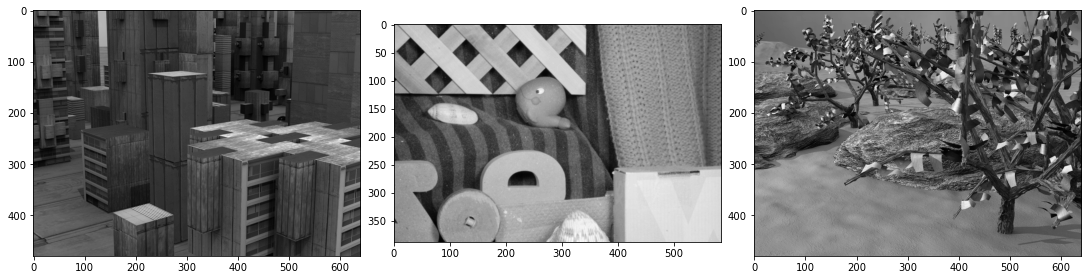

In [329]:
image_1 = cv2.imread('../data/all-frames-colour/Urban2/frame07.png', 0)
image_2 = cv2.imread('../data/all-frames-colour/RubberWhale/frame07.png',0)
image_3 = cv2.imread('../data/all-frames-colour/Grove3/frame07.png',0)

fig, axes = plt.subplots(1,3,figsize=(15,5), constrained_layout=True)
axes[0].imshow(image_1, cmap='gray')
axes[1].imshow(image_2, cmap='gray')
axes[2].imshow(image_3, cmap='gray')

In [330]:
# responses from harris detector
response_h_1 = harris_shiTomasi(image_1, patch_size =(3,3), k=0.06, detector=0)
response_h_2 = harris_shiTomasi(image_2, patch_size =(3,3), k=0.06, detector=0)
response_h_3 = harris_shiTomasi(image_3, patch_size =(3,3), k=0.06, detector=0)

In [334]:
# responses from shi-tomasi corner detector
response_s_1 = harris_shiTomasi(image_1, k=0.01,detector=1)
response_s_2 = harris_shiTomasi(image_2, k=0.01,detector=1)
response_s_3 = harris_shiTomasi(image_3, k=0.01,detector=1)

In [4]:
def extractCornersFromResponseMatrix(response, no_of_corners = 100):
    """
        This function extracts corners from the given response, by choosing a suitable treshold, 
        which will give the optimal no of points.
    """
    # Starting value of the threshold, which will control the number of points we get
    threshold = 0.01
    # by which the threshold should change when the count is not matched
    change = 0.1
    
    # Maximum value of the elements in the given responses array
    maximum_element = np.max(response)
    # Previous count to see the change in counts
    prev_count = np.sum(response>threshold*maximum_element)
    
    if prev_count>no_of_corners:
        direction = 1
    else:
        direction = -1
    
    while True:
        count = np.sum(response>threshold*maximum_element)
        if count==no_of_corners:
            break;
        
        # Switch direction when overshoot or under shoot. Decrease the change by 10%

        if ((count<no_of_corners and prev_count>no_of_corners) or (count>no_of_corners and prev_count<no_of_corners)):
            direction*=-1
            change*=0.9
        threshold+=direction*change
        prev_count = count
    
    y, x = np.where(response>threshold*maximum_element)
    return list(zip(x,y))

In [5]:
def drawCorners(image, response, counts):
    corners = extractCornersFromResponseMatrix(response, counts)
    display_image = cv2.cvtColor(image.copy(),cv2.COLOR_GRAY2RGB)
    for corner in corners:
        display_image = cv2.circle(display_image, corner, 3, [255,0,0], -1)
    return display_image

In [6]:
def plotCorners(images, responses, corner_counts, title):
    """
        This function plots the corners for the given images with their respective response matirces and thresholds
    """
    fig, axes = plt.subplots(1,3,figsize=(15,5), constrained_layout=True)
    n = len(images)
    for i in range(n):
        axes[i].imshow(drawCorners(images[i], responses[i], corner_counts[i]))
    fig.suptitle(title, size=25)

In [332]:
images = [image_1, image_2, image_3]
harris_responses = [response_h_1, response_h_2, response_h_3]
shi_tomasi_responses = [response_s_1, response_s_2, response_s_3]

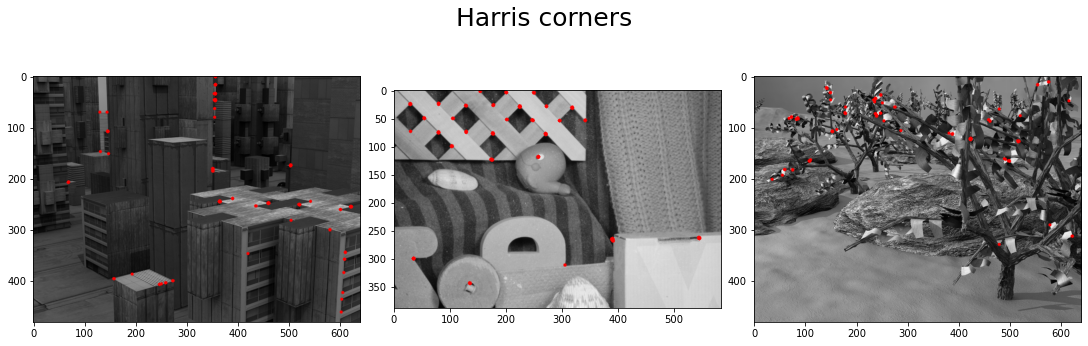

In [354]:
plotCorners(images, harris_responses, [100,100,100], "Harris corners")

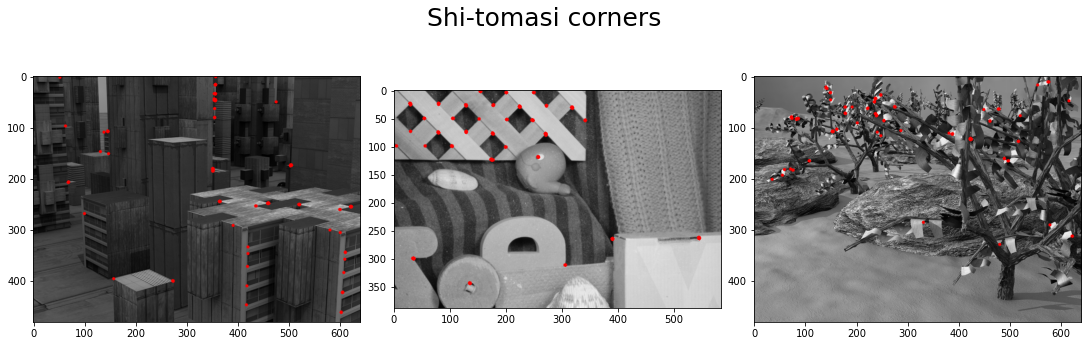

In [351]:
plotCorners(images, shi_tomasi_responses, [100,100,100], "Shi-tomasi corners")

In [360]:
def LukasKanadeForwardAdditive(Img1, Img2, windowSize, no_of_corners = 100):
    
    response_1 = harris_shiTomasi(Img1, detector=1)
    # response_2 = harris_shiTomasi(Img2, detector=1)
    
    # extracting 100 corners from each of the response matrix
    corners_1 = extractCornersFromResponseMatrix(response_1, no_of_corners)
    # corners_2 = extractCornersFromResponseMatrix(response_2, 300)
    
    # d_x = np.array([[-1,S0,1]])
    # d_y = d_x.T
    
    # gradient_x = ndimage.convolve(Img1, d_x)
    # gradient_y = ndimage.convolve(Img2, d_y)
    gradient_x = cv2.Sobel(Img1,cv2.CV_64F,1,0,ksize=3)
    gradient_y = cv2.Sobel(Img1,cv2.CV_64F,0,1,ksize=3)
    
    I_t = Img2-Img1
    
    I_xx = gradient_x**2
    I_yy = gradient_y**2
    I_xy = gradient_x*gradient_y
    I_xt = gradient_x*I_t
    I_yt = gradient_y*I_t
    
    m1, n1 = Img1.shape
    m2, n2 = Img2.shape
    
    
    offset_x = windowSize[0]//2
    offset_y = windowSize[1]//2
    
    displacement = dict()
    
    for corner in corners_1:
        y, x = corner
        # If we get a points near the border of the image, it will not be possible to get a patch of desired size.
        if x+offset_x>m1 or y+offset_y>n1 or x-offset_x<0 or y-offset_y<0:
            continue
        S_xx = np.sum(I_xx[x-offset_x:x+offset_x+1, y-offset_y:y+offset_y+1])
        S_yy = np.sum(I_yy[x-offset_x:x+offset_x+1, y-offset_y:y+offset_y+1])
        S_xy = np.sum(I_xy[x-offset_x:x+offset_x+1, y-offset_y:y+offset_y+1])
        S_xt = np.sum(I_xt[x-offset_x:x+offset_x+1, y-offset_y:y+offset_y+1])
        S_yt = np.sum(I_yt[x-offset_x:x+offset_x+1, y-offset_y:y+offset_y+1])
        
        AT_A = np.array([[S_xx, S_xy],[S_xy, S_yy]])
        
        min_lambda = np.min(np.linalg.eigvals(AT_A))
        
        threshold_tau = 0.01
        if threshold_tau > min_lambda:
            continue
        
        AT_b = -1*np.array([[S_xt],[S_yt]])
        
        displacement[corner] = np.dot(np.linalg.pinv(AT_A), AT_b)
        
    return displacement

In [361]:
frame1 = cv2.imread('../data/all-frames-colour/RubberWhale/frame07.png',0)/255
frame2 = cv2.imread('../data/all-frames-colour/RubberWhale/frame08.png',0)/255

In [385]:
displacement = LukasKanadeForwardAdditive(frame1, frame2, (25,25), no_of_corners=500)

In [397]:
def displayOpticalFlow(in_image, displacement, normalized=False):
    """
        The function plots the quiver plots on the image,
        arguments:
            image - input image
            velocities - u and v velocities
            normalized - tells whether the image is normalized or not
    """
    image = in_image.copy()
    if normalized:
        image*=255
        image = image.astype(np.uint8)
    image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
    
    positions = np.array(list(displacement.keys()))
    # x_position = positions[:,0]
    # y_position = positions[:,1]
    
    # ORIG: displacement = np.array(list(displacement.values())).reshape((-1,2))
    
    displacement = positions + (np.array(list(displacement.values()))*100).reshape((-1,2)).astype(np.int32)
    
    # test2
    # displacement = (np.array(list(displacement.values()))*100).reshape((-1,2)).astype(np.int32)
    # displacement = np.vstack((displacement[:,1], displacement[:,0])).T
    # displacement = positions + displacement
    # test
    # x_direction = displacement[:,0]
    # y_direction = displacement[:,1]
    
    plt.figure(figsize=(12,12))
    for i in range(len(displacement)):
        image = cv2.arrowedLine(image, tuple(positions[i]), tuple(displacement[i]), (0,255,0), 1,cv2.LINE_AA,0,0.5)
    plt.imshow(image)

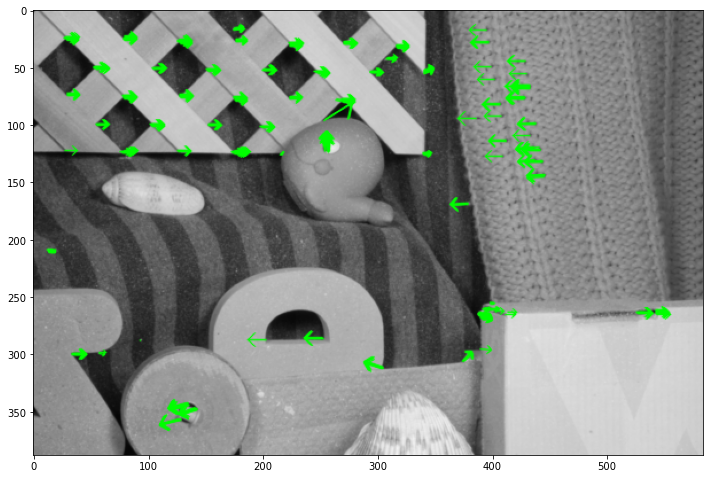

In [387]:
displayOpticalFlow(frame1, displacement, normalized=True)

# Rough

In [378]:
test_image_1 = cv2.imread(r'../data/all-frames-colour/RubberWhale/frame08.png',0)
test_image_2 = cv2.imread(r'../data/all-frames-colour/RubberWhale/frame09.png',0)

In [379]:
corners_1 = cv2.goodFeaturesToTrack(test_image_1, 500,0.01,10)

In [380]:
corners_1 = corners_1.reshape((-1,2)).astype(np.int16)

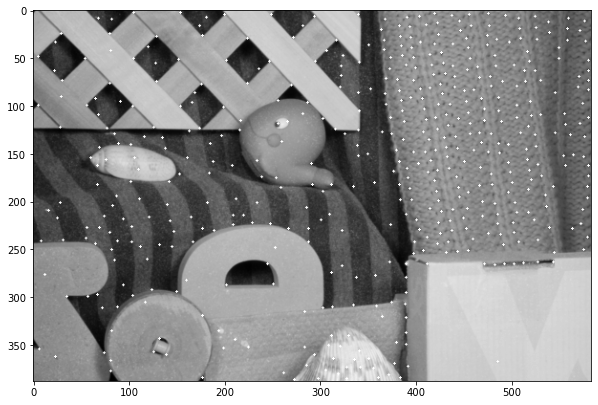

In [381]:
display_image = test_image_1.copy()
for corner in corners_1:
    display_image = cv2.circle(display_image, tuple(corner), 1, (255,255,255),-1 )
plt.figure(figsize=(10,10))
plt.imshow(display_image, cmap='gray')

In [382]:
test_image_1 = test_image_1/255
test_image_2 = test_image_2/255

In [390]:
gradient_x = cv2.Sobel(test_image_1,cv2.CV_64F,1,0,ksize=3)
gradient_y = cv2.Sobel(test_image_1,cv2.CV_64F,0,1,ksize=3)

I_t = test_image_2-test_image_1

I_xx = gradient_x**2
I_yy = gradient_y**2
I_xy = gradient_x*gradient_y
I_xt = gradient_x*I_t
I_yt = gradient_y*I_t

m1, n1 = test_image_1.shape

windowSize = (25,25)

offset_x = windowSize[0]//2
offset_y = windowSize[1]//2

displacement = dict()

for corner in corners_1:
    # Reverse the corners, as y represents the rows and the x represents the columns
    y, x = corner
    # If we get a points near the border of the image, it will not be possible to get a patch of desired size.
    if x+offset_x>m1 or y+offset_y>n1 or x-offset_x<0 or y-offset_y<0:
        continue
    S_xx = np.sum(I_xx[x-offset_x:x+offset_x+1, y-offset_y:y+offset_y+1])
    S_yy = np.sum(I_yy[x-offset_x:x+offset_x+1, y-offset_y:y+offset_y+1])
    S_xy = np.sum(I_xy[x-offset_x:x+offset_x+1, y-offset_y:y+offset_y+1])
    S_xt = np.sum(I_xt[x-offset_x:x+offset_x+1, y-offset_y:y+offset_y+1])
    S_yt = np.sum(I_yt[x-offset_x:x+offset_x+1, y-offset_y:y+offset_y+1])

    AT_A = np.array([[S_xx, S_xy],[S_xy, S_yy]])

    # min_lambda = np.min(np.linalg.eigvals(AT_A))

    # threshold_tau = 0.01
    # if threshold_tau > min_lambda:
    #     continue

    AT_b = -1*np.array([[S_xt],[S_yt]])

    displacement[tuple(corner)] = np.dot(np.linalg.pinv(AT_A), AT_b).ravel()

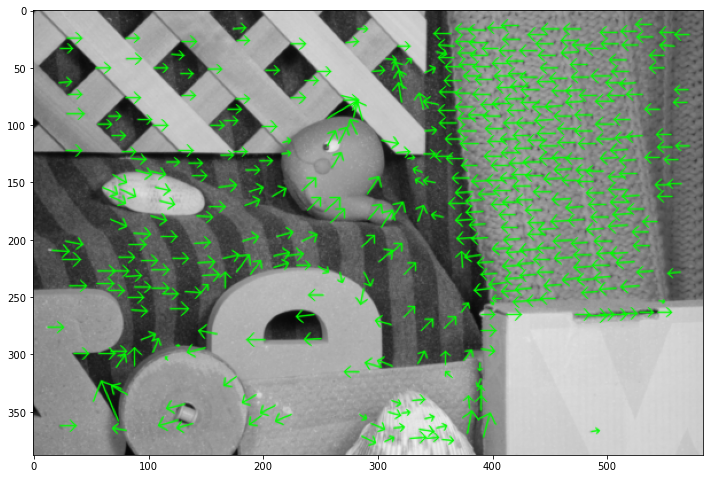

In [396]:
displayOpticalFlow(test_image_1, displacement, normalized=True)

# Helper code

In [28]:

UNKNOWN_FLOW_THRESH = 1e7
def show_flow(filename):
    """
    visualize optical flow map using matplotlib
    :param filename: optical flow file
    :return: None
    """
    flow = read_flow(filename)
    img = flow_to_image(flow)
    plt.imshow(img)
    plt.show()

def read_flow(filename):
    """
    read optical flow from Middlebury .flo file
    :param filename: name of the flow file
    :return: optical flow data in matrix
    """
    f = open(filename, 'rb')
    magic = np.fromfile(f, np.float32, count=1)
    data2d = None

    if 202021.25 != magic:
        print ('Magic number incorrect. Invalid .flo file')
    else:
        w = int(np.fromfile(f, np.int32, count=1)[0])
        h = int(np.fromfile(f, np.int32, count=1)[0])
        #print("Reading %d x %d flo file" % (h, w))
        data2d = np.fromfile(f, np.float32, count=2 * w * h)
        # reshape data into 3D array (columns, rows, channels)
        data2d = np.resize(data2d, (h, w, 2))
    f.close()
    return data2d

def flow_to_image(flow):
    """
    Convert flow into middlebury color code image
    :param flow: optical flow map
    :return: optical flow image in middlebury color
    """
    u = flow[:, :, 0]
    v = flow[:, :, 1]

    maxu = -999.
    maxv = -999.
    minu = 999.
    minv = 999.

    idxUnknow = (abs(u) > UNKNOWN_FLOW_THRESH) | (abs(v) > UNKNOWN_FLOW_THRESH)
    u[idxUnknow] = 0
    v[idxUnknow] = 0

    maxu = max(maxu, np.max(u))
    minu = min(minu, np.min(u))

    maxv = max(maxv, np.max(v))
    minv = min(minv, np.min(v))

    rad = np.sqrt(u ** 2 + v ** 2)
    maxrad = max(-1, np.max(rad))

    u = u/(maxrad + np.finfo(float).eps)
    v = v/(maxrad + np.finfo(float).eps)

    img = compute_color(u, v)

    idx = np.repeat(idxUnknow[:, :, np.newaxis], 3, axis=2)
    img[idx] = 0

    return np.uint8(img)


def compute_color(u, v):
    """
    compute optical flow color map
    :param u: optical flow horizontal map
    :param v: optical flow vertical map
    :return: optical flow in color code
    """
    [h, w] = u.shape
    img = np.zeros([h, w, 3])
    nanIdx = np.isnan(u) | np.isnan(v)
    u[nanIdx] = 0
    v[nanIdx] = 0

    colorwheel = make_color_wheel()
    ncols = np.size(colorwheel, 0)

    rad = np.sqrt(u**2+v**2)

    a = np.arctan2(-v, -u) / np.pi

    fk = (a+1) / 2 * (ncols - 1) + 1

    k0 = np.floor(fk).astype(int)

    k1 = k0 + 1
    k1[k1 == ncols+1] = 1
    f = fk - k0

    for i in range(0, np.size(colorwheel,1)):
        tmp = colorwheel[:, i]
        col0 = tmp[k0-1] / 255
        col1 = tmp[k1-1] / 255
        col = (1-f) * col0 + f * col1

        idx = rad <= 1
        col[idx] = 1-rad[idx]*(1-col[idx])
        notidx = np.logical_not(idx)

        col[notidx] *= 0.75
        img[:, :, i] = np.uint8(np.floor(255 * col*(1-nanIdx)))

    return img


def make_color_wheel():
    """
    Generate color wheel according Middlebury color code
    :return: Color wheel
    """
    RY = 15
    YG = 6
    GC = 4
    CB = 11
    BM = 13
    MR = 6

    ncols = RY + YG + GC + CB + BM + MR

    colorwheel = np.zeros([ncols, 3])

    col = 0

    # RY
    colorwheel[0:RY, 0] = 255
    colorwheel[0:RY, 1] = np.transpose(np.floor(255*np.arange(0, RY) / RY))
    col += RY

    # YG
    colorwheel[col:col+YG, 0] = 255 - np.transpose(np.floor(255*np.arange(0, YG) / YG))
    colorwheel[col:col+YG, 1] = 255
    col += YG

    # GC
    colorwheel[col:col+GC, 1] = 255
    colorwheel[col:col+GC, 2] = np.transpose(np.floor(255*np.arange(0, GC) / GC))
    col += GC

    # CB
    colorwheel[col:col+CB, 1] = 255 - np.transpose(np.floor(255*np.arange(0, CB) / CB))
    colorwheel[col:col+CB, 2] = 255
    col += CB

    # BM
    colorwheel[col:col+BM, 2] = 255
    colorwheel[col:col+BM, 0] = np.transpose(np.floor(255*np.arange(0, BM) / BM))
    col += + BM

    # MR
    colorwheel[col:col+MR, 2] = 255 - np.transpose(np.floor(255 * np.arange(0, MR) / MR))
    colorwheel[col:col+MR, 0] = 255

    return colorwheel

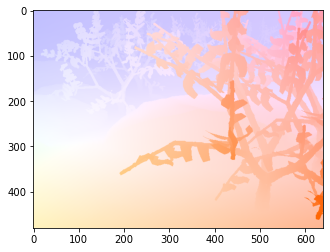

In [39]:
show_flow('../data/ground-truth-flow/Grove3/flow10.flo')